# Rule mining on 5JUN2023 data (median split into two classes)
References
* https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/
* https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/
* https://www.datacamp.com/tutorial/association-rule-mining-python
* https://ajaytech.co/python-association-rule-learning/

## Metrics
Given a rule "A -> C", A stands for antecedent and C stands for consequent.  

**support**  
Support is a measure of how frequently an item or itemset appears in the dataset. It is calculated as the number of transactions containing the item(s) divided by the total number of transactions in the dataset. High support indicates that an item or itemset is common in the dataset, while low support indicates that it is rare.
The support metric is defined for itemsets, not assocication rules.  

`support(A) = The proportion of transactions that contain A.`
`support(A -> C) = The proportion of transactions that contain both A and C.`

**confidence**
Confidence is a measure of the strength of the association between two items. It is calculated as the number of transactions containing both items divided by the number of transactions containing the first item. High confidence indicates that the presence of the first item is a strong predictor of the presence of the second item.

`confidence(A -> C) = support(A -> C)/support(C)`

**lift**  
Lift measures how much more often the antecedent and consequent of a rule (A -> C) occur together than we would expect if they were statistically independent. If A and C are independent, the lift score will be exactly 1.  

`lift(A -> C) = confidence(A -> C) / support(C)`

**leverage**  
Leverage computes the difference between the observed frequency of A and C appearing together and the frequency that would be expected if A and C were independent. A leverage value of 0 indicates independence.

`leverage(A ->) = support(A -> C) - support(A)xsupport(C)`

**conviction**  

A high conviction value means that the consequent is highly depending on the antecedent. For instance, in the case of a perfect confidence score, the denominator becomes 0 (due to 1 - 1) for which the conviction score is defined as 'inf'. Similar to lift, if items are independent, the conviction is 1.  

`conviction(A -> C) = (1 - support(C)) / (1 - confidence(A -> C))`

**zhangs_metric**  
Measures both association and dissociation. Value ranges between -1 and 1. A positive value (>0) indicates Association and negative value indicated dissociation.  

`zhangs_metric = (confidence(A -> C) - confidence(A' -> C)) / Max(confidence(A -> C), confidence(A' -> C))`

References  
[1] Tan, Steinbach, Kumar. Introduction to Data Mining. Pearson New International Edition. Harlow: Pearson Education Ltd., 2014. (pp. 327-414).

[2] Michael Hahsler, https://michael.hahsler.net/research/association_rules/measures.html

[3] R. Agrawal, T. Imielinski, and A. Swami. Mining associations between sets of items in large databases. In Proc. of the ACM SIGMOD Int'l Conference on Management of Data, pages 207-216, Washington D.C., May 1993

[4] S. Brin, R. Motwani, J. D. Ullman, and S. Tsur. Dynamic itemset counting and implication rules for market basket data

[5] Piatetsky-Shapiro, G., Discovery, analysis, and presentation of strong rules. Knowledge Discovery in Databases, 1991: p. 229-248.

[6] Sergey Brin, Rajeev Motwani, Jeffrey D. Ullman, and Shalom Turk. Dynamic itemset counting and implication rules for market basket data. In SIGMOD 1997, Proceedings ACM SIGMOD International Conference on Management of Data, pages 255-264, Tucson, Arizona, USA, May 1997

[7] Xiaowei Yan , Chengqi Zhang & Shichao Zhang (2009) CONFIDENCE METRICS FOR ASSOCIATION RULE MINING, Applied Artificial Intelligence, 23:8, 713-737 https://www.tandfonline.com/doi/pdf/10.1080/08839510903208062.


---

In [1]:
%load_ext autoreload
%autoreload 2

In [217]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules, fpmax, fpgrowth
from mlxtend.preprocessing import TransactionEncoder

---

## one hot encode data
To use rule mining the data needs to be one hot encoded

In [13]:
# load data
df = (
    pd.read_csv("../data/5JUN2023_Provisional_endo_study_data_to_test_AI.csv")
      .dropna()
)
df['Sex'] = np.where(df.Sex == "male", 'Male', 'Female')

# keep track of columns holding class/categorical and numerical values
numerical_cols = [col for col in df.columns if col != 'Sex']
feature_cols = ['Sex'] + numerical_cols
target_col = "DSA_1st_week_infusions"

cls_cols = [f'{col}_cls' for col in df.columns if col != 'Sex']
cls_feature_cols = ['Sex'] + cls_cols
cls_target_col = "DSA_1st_week_infusions_cls"

# create datafame with class/categorical values
cut_ranges = dict()
cls_df = pd.DataFrame(columns=cls_feature_cols)
cls_range_df = pd.DataFrame(columns=cls_feature_cols)
for col in df.columns:
    if col != 'Sex':
        cls_df[f'{col}_cls'] = pd.cut(df[col], bins=2, labels=['low', 'high'], include_lowest=True)
        cut_ranges[col] = pd.cut(df[col].to_numpy(), bins=2)
        cut_ranges[col] = list(cut_ranges[col].categories)
    else:
        cls_df[col] = df[col]

# use cls_df and columns holding class/categorical values to create a one hot encoding
# dummy_df = pd.get_dummies(cls_df[cls_cols]) # one hot encode class columns
# oh_df = pd.concat([cls_df[['Sex']], dummy_df], axis=1) # merge with female values
oh_df = pd.get_dummies(cls_df) # one hot encode class columns
# oh_df = pd.concat([cls_df[['Sex']], dummy_df], axis=1) # merge with female values

# keep track of feature and target columns in one hot datafame
oh_target_cols = ["DSA_1st_week_infusions_cls_low", "DSA_1st_week_infusions_cls_high"]
oh_feature_cols = [col for col in oh_df.columns if col not in oh_target_cols]

# replace true and false with 1 and 0 in one hot data
# oh_df = oh_df.applymap(lambda x: 1 if x else 0)

# cls_df = cls_df.replace('low', 0).replace('med', 1).replace('high', 2)
# cls_df = cls_df.astype(int) # set category data types to int (as opposed to category)
# print(cls_df.head())
oh_df.head()

,Sex_Female,Sex_Male,A_EPM_distance_cls_low,A_EPM_distance_cls_high,A_EPM_pct_open_arms_cls_low,A_EPM_pct_open_arms_cls_high,A_Open_field_distance_cls_low,A_Open_field_distance_cls_high,A_LOF_pct_center_cls_low,A_LOF_pct_center_cls_high,...,FSA_Consumption_time_cls_low,FSA_Consumption_time_cls_high,DSA_1st_week_infusions_cls_low,DSA_1st_week_infusions_cls_high,OPAD_37oC__lick_face_cls_low,OPAD_37oC__lick_face_cls_high,OPAD_46_5oC_lick_face_cls_low,OPAD_46_5oC_lick_face_cls_high,RP_Delta_hargreaves_cls_low,RP_Delta_hargreaves_cls_high
0,False,True,False,True,False,True,False,True,False,True,...,True,False,True,False,True,False,True,False,True,False
1,False,True,False,True,False,True,True,False,False,True,...,False,True,True,False,False,True,False,True,True,False
2,False,True,False,True,False,True,False,True,False,True,...,True,False,True,False,True,False,False,True,True,False
3,False,True,False,True,False,True,False,True,True,False,...,True,False,True,False,True,False,False,True,True,False
4,False,True,True,False,True,False,True,False,True,False,...,True,False,True,False,False,True,False,True,False,True


In [220]:
# te = TransactionEncoder()
# te.fit_transform(oh_df)

save one hot dataframe in case it needs to be loaded by another application

In [14]:
# oh_df.to_csv('../data/5JUN2023_Provisional_endo_study_data_to_test_AI_one_hot.csv', index=False)
oh_df.replace(False, 0).replace(True, 1).to_csv('../data/5JUN2023_Provisional_endo_study_data_to_test_AI_one_hot_two_classes.csv', index=False)

---

display intervals used for cutoffs

In [17]:
cut_df = pd.DataFrame(cut_ranges).transpose()
cut_df.columns = ['low', 'high']
cut_df

,low,high
A_EPM_distance,"(832.481, 1262.98]","(1262.98, 1692.62]"
A_EPM_pct_open_arms,"(-0.0371, 18.57]","(18.57, 37.14]"
A_Open_field_distance,"(3331.541, 5124.785]","(5124.785, 6914.45]"
A_LOF_pct_center,"(0.041, 9.56]","(9.56, 19.06]"
RP_Withdrawal_latency,"(11.374, 14.47]","(14.47, 17.56]"
OR_lick_time,"(77.113, 158.238]","(158.238, 239.2]"
OR_num_lick_bursts,"(55.669, 96.25]","(96.25, 136.75]"
OR__Lick_burst_length,"(1.132, 1.523]","(1.523, 1.913]"
FSA_Consumption_time,"(29.371, 68.99]","(68.99, 108.53]"
DSA_1st_week_infusions,"(85.912, 130.0]","(130.0, 174.0]"


---

calculate counts for class

In [18]:
# all mice
all_count_df = pd.DataFrame(columns=['low', 'high'], index=cls_df[cls_cols].columns)
for col in cls_df[cls_cols].columns:
    all_count_df.loc[col, 'low'] = cls_df[col].value_counts().loc['low']
    all_count_df.loc[col, 'high'] = cls_df[col].value_counts().loc['high']
# all_count_df

# male mice
temp_df = cls_df[cls_cols].loc[cls_df.Sex == 'Male']
male_count_df = pd.DataFrame(columns=['low', 'high'], index=cls_df[cls_cols].columns)
for col in temp_df.columns:
    male_count_df.loc[col, 'low'] = temp_df[col].value_counts().loc['low']
    male_count_df.loc[col, 'high'] = temp_df[col].value_counts().loc['high']
# male_count_df

# female mice
temp_df = cls_df[cls_cols].loc[cls_df.Sex == 'Female']
female_count_df = pd.DataFrame(columns=['low', 'high'], index=cls_df[cls_cols].columns)
for col in temp_df.columns:
    female_count_df.loc[col, 'low'] = temp_df[col].value_counts().loc['low']
    female_count_df.loc[col, 'high'] = temp_df[col].value_counts().loc['high']
# female_count_df

In [19]:
all_count_df

,low,high
A_EPM_distance_cls,7,8
A_EPM_pct_open_arms_cls,6,9
A_Open_field_distance_cls,8,7
A_LOF_pct_center_cls,9,6
RP_Withdrawal_latency_cls,9,6
OR_lick_time_cls,5,10
OR_num_lick_bursts_cls,10,5
OR__Lick_burst_length_cls,12,3
FSA_Consumption_time_cls,11,4
DSA_1st_week_infusions_cls,11,4


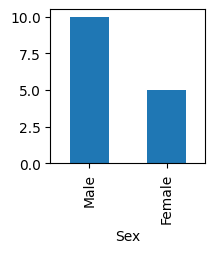

In [20]:
plt.figure(figsize=(2,2))
cls_df.Sex.value_counts().plot.bar()
plt.show()

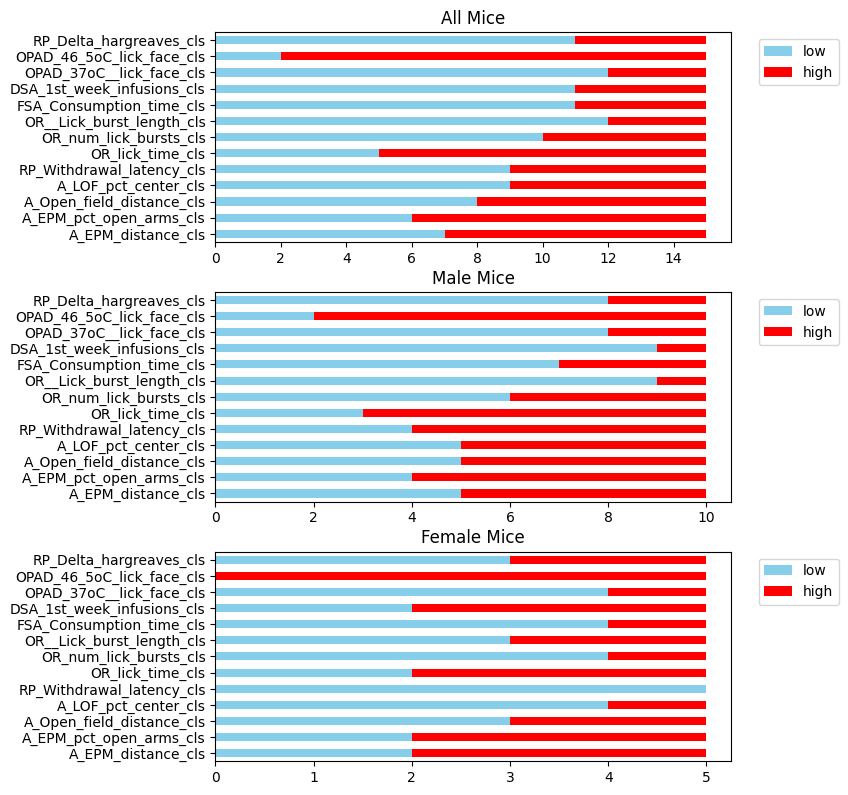

In [22]:
# plt.figure(figsize=(10, 100))
fig, axs = plt.subplots(3,1, figsize=(6, 8))
fig.tight_layout(pad=1.5)

all_count_df.plot(ax=axs[0], kind='barh', stacked=True, color=['skyblue', 'red'])
axs[0].set_title('All Mice')
axs[0].legend(bbox_to_anchor=(1.04, 1), loc="upper left")

male_count_df.plot(ax=axs[1], kind='barh', stacked=True, color=['skyblue', 'red'])
axs[1].set_title('Male Mice')
axs[1].legend(bbox_to_anchor=(1.04, 1), loc="upper left")

female_count_df.plot(ax=axs[2], kind='barh', stacked=True, color=['skyblue', 'red'])
axs[2].set_title('Female Mice')
axs[2].legend(bbox_to_anchor=(1.04, 1), loc="upper left")

plt.show()

---

## assocation rules

In [23]:
pd.set_option('display.max_colwidth', None) # needed to see all values in dataframe

helper functions for checking of item is in the set

In [131]:
# returns bool about whether the target items are in x
def includes_target(x, target_items = set(oh_target_cols)):
    return target_items.intersection(x) != set() # bool for empty intersection

# returns a bool about whether the ONLY items in x are target items
def only_includes_target(x, target_items = set(oh_target_cols)):
    if isinstance(target_items, set) or isinstance(target_items, frozenset): # note: x must be a set
        temp = x.difference(target_items)
    else:
        temp = x.difference({target_items})

    return len(temp) == 0 # after removing targets, length should be zero

set(oh_target_cols)

{'DSA_1st_week_infusions_cls_high', 'DSA_1st_week_infusions_cls_low'}

---

**build itemsets from one hot encodings**  
Use `min_support` to specify the minimum support/frequency.

In [221]:
frequent_itemsets = apriori(oh_df, min_support=0.2, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x)) # add length info
frequent_itemsets.head()

,support,itemsets,length
0,0.333333,(Sex_Female),1
1,0.666667,(Sex_Male),1
2,0.466667,(A_EPM_distance_cls_low),1
3,0.533333,(A_EPM_distance_cls_high),1
4,0.400000,(A_EPM_pct_open_arms_cls_low),1


In [228]:
frequent_itemsets[frequent_itemsets.length ==1]

,support,itemsets,length
0,0.333333,(Sex_Female),1
1,0.666667,(Sex_Male),1
2,0.466667,(A_EPM_distance_cls_low),1
3,0.533333,(A_EPM_distance_cls_high),1
4,0.400000,(A_EPM_pct_open_arms_cls_low),1
5,0.600000,(A_EPM_pct_open_arms_cls_high),1
6,0.533333,(A_Open_field_distance_cls_low),1
7,0.466667,(A_Open_field_distance_cls_high),1
8,0.600000,(A_LOF_pct_center_cls_low),1
9,0.400000,(A_LOF_pct_center_cls_high),1


In [229]:
frequent_itemsets[frequent_itemsets.length ==1]['support'].sum()

13.866666666666667

In [230]:
0.2666667 * 15

4.0000005

In [231]:
oh_df.FSA_Consumption_time_cls_high.sum()

4

In [232]:
0.666667 * 15

10.000005

In [233]:
oh_df.OR_lick_time_cls_high.sum()

10

In [234]:
frequent_itemsets[frequent_itemsets.length ==2]

,support,itemsets,length
27,0.200000,"(Sex_Female, A_EPM_distance_cls_high)",2
28,0.200000,"(A_EPM_pct_open_arms_cls_high, Sex_Female)",2
29,0.200000,"(A_Open_field_distance_cls_low, Sex_Female)",2
30,0.266667,"(Sex_Female, A_LOF_pct_center_cls_low)",2
31,0.333333,"(Sex_Female, RP_Withdrawal_latency_cls_low)",2
...,...,...,...
248,0.600000,"(OPAD_37oC__lick_face_cls_low, RP_Delta_hargreaves_cls_low)",2
249,0.200000,"(OPAD_37oC__lick_face_cls_low, RP_Delta_hargreaves_cls_high)",2
250,0.200000,"(OPAD_46_5oC_lick_face_cls_high, OPAD_37oC__lick_face_cls_high)",2
251,0.600000,"(OPAD_46_5oC_lick_face_cls_high, RP_Delta_hargreaves_cls_low)",2


In [235]:
0.2 * 15

3.0

In [238]:
oh_df[(oh_df.Sex_Female) & (oh_df.A_EPM_distance_cls_high)]

,Sex_Female,Sex_Male,A_EPM_distance_cls_low,A_EPM_distance_cls_high,A_EPM_pct_open_arms_cls_low,A_EPM_pct_open_arms_cls_high,A_Open_field_distance_cls_low,A_Open_field_distance_cls_high,A_LOF_pct_center_cls_low,A_LOF_pct_center_cls_high,...,FSA_Consumption_time_cls_low,FSA_Consumption_time_cls_high,DSA_1st_week_infusions_cls_low,DSA_1st_week_infusions_cls_high,OPAD_37oC__lick_face_cls_low,OPAD_37oC__lick_face_cls_high,OPAD_46_5oC_lick_face_cls_low,OPAD_46_5oC_lick_face_cls_high,RP_Delta_hargreaves_cls_low,RP_Delta_hargreaves_cls_high
13,True,False,False,True,False,True,True,False,True,False,...,False,True,False,True,True,False,False,True,True,False
15,True,False,False,True,True,False,False,True,False,True,...,True,False,True,False,True,False,False,True,False,True
18,True,False,False,True,False,True,False,True,True,False,...,True,False,False,True,False,True,False,True,True,False


In [225]:
len(oh_df.columns) 

28

In [226]:
len(oh_df)

15

In [227]:
frequent_itemsets.support.sum()

1559.666666666667

---

**build rules dataframe**  
Use `min_threshold` to specify the minimum support/frequency.

In [254]:
rules = association_rules(frequent_itemsets, metric="support", min_threshold=0.2)
len(rules)

289418

**specify filters**  
- `filter1`: We are only interested in consequents that contain DSA data: `DSA_1st_week_infusions_cls_low`, `DSA_1st_week_infusions_cls_high`
- `filter2`: At a minimum, we want the consequents to be supported by 20% of the data.
- `filter3`: Only in include antecedents with 2 more fields.
- `filter4`: Only in include consequents with 2 more fields.
- `filter5`: Restrict consequent to only 1 field (i.e., have length == 1).
- `filter6`: The consequents only include DSA targets (may have length > 1).

In [133]:
filter1 = rules['consequents'].apply(lambda x: includes_target(x))
filter2 = rules['consequent support'] > 0.2
filter3 = rules['antecedents'].apply(lambda x: len(x) > 1)
filter4 = rules['consequents'].apply(lambda x: len(x) > 1)
filter5 = rules['consequents'].apply(lambda x: len(x) == 1)
filter6 = rules['consequents'].apply(lambda x: only_includes_target(x))

**rules which ONLY contain a DSA variable in the consequent**

In [137]:
rules[filter6].sort_values(by='lift', ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
2470,"(RP_Withdrawal_latency_cls_low, A_LOF_pct_center_cls_low)",(DSA_1st_week_infusions_cls_high),0.466667,0.266667,0.266667,0.571429,2.142857,0.142222,1.711111,1.0
10566,"(OPAD_46_5oC_lick_face_cls_high, RP_Withdrawal_latency_cls_low, A_LOF_pct_center_cls_low)",(DSA_1st_week_infusions_cls_high),0.466667,0.266667,0.266667,0.571429,2.142857,0.142222,1.711111,1.0
2901,"(OPAD_46_5oC_lick_face_cls_high, RP_Withdrawal_latency_cls_low)",(DSA_1st_week_infusions_cls_high),0.600000,0.266667,0.266667,0.444444,1.666667,0.106667,1.320000,1.0
239,(RP_Withdrawal_latency_cls_low),(DSA_1st_week_infusions_cls_high),0.600000,0.266667,0.266667,0.444444,1.666667,0.106667,1.320000,1.0
2637,"(OPAD_46_5oC_lick_face_cls_high, A_LOF_pct_center_cls_low)",(DSA_1st_week_infusions_cls_high),0.600000,0.266667,0.266667,0.444444,1.666667,0.106667,1.320000,1.0


**rules which contain a DSA variable in the consequent (may have others), and have 2 or more antecedences**

In [138]:
rules[filter1 & filter3].sort_values(by='lift', ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
46377,"(A_EPM_pct_open_arms_cls_high, Sex_Male, A_Open_field_distance_cls_high)","(OR__Lick_burst_length_cls_low, OPAD_37oC__lick_face_cls_low, A_EPM_distance_cls_high, RP_Delta_hargreaves_cls_low, DSA_1st_week_infusions_cls_low)",0.266667,0.266667,0.266667,1.0,3.75,0.195556,inf,1.0
46397,"(OPAD_37oC__lick_face_cls_low, Sex_Male, A_EPM_distance_cls_high)","(A_EPM_pct_open_arms_cls_high, OR__Lick_burst_length_cls_low, RP_Delta_hargreaves_cls_low, A_Open_field_distance_cls_high, DSA_1st_week_infusions_cls_low)",0.266667,0.266667,0.266667,1.0,3.75,0.195556,inf,1.0
28601,"(OPAD_37oC__lick_face_cls_low, Sex_Male, A_EPM_distance_cls_high)","(A_EPM_pct_open_arms_cls_high, DSA_1st_week_infusions_cls_low, A_Open_field_distance_cls_high)",0.266667,0.266667,0.266667,1.0,3.75,0.195556,inf,1.0
46288,"(A_EPM_pct_open_arms_cls_high, OPAD_37oC__lick_face_cls_low, OR__Lick_burst_length_cls_low, A_EPM_distance_cls_high)","(A_Open_field_distance_cls_high, DSA_1st_week_infusions_cls_low, Sex_Male, RP_Delta_hargreaves_cls_low)",0.266667,0.266667,0.266667,1.0,3.75,0.195556,inf,1.0
41439,"(A_EPM_pct_open_arms_cls_high, OPAD_37oC__lick_face_cls_low, Sex_Male, A_EPM_distance_cls_high)","(A_Open_field_distance_cls_high, DSA_1st_week_infusions_cls_low, RP_Delta_hargreaves_cls_low)",0.266667,0.266667,0.266667,1.0,3.75,0.195556,inf,1.0


**rules which contain a DSA variable in the consequent (may have others), and have 2 or more consequents**

In [140]:
rules[filter1 & filter4].sort_values(by='lift', ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
41489,"(OPAD_37oC__lick_face_cls_low, Sex_Male, A_EPM_distance_cls_high)","(A_EPM_pct_open_arms_cls_high, A_Open_field_distance_cls_high, DSA_1st_week_infusions_cls_low, RP_Delta_hargreaves_cls_low)",0.266667,0.266667,0.266667,1.0,3.75,0.195556,inf,1.0
46323,"(OPAD_37oC__lick_face_cls_low, OR__Lick_burst_length_cls_low, RP_Delta_hargreaves_cls_low, A_EPM_distance_cls_high)","(A_EPM_pct_open_arms_cls_high, DSA_1st_week_infusions_cls_low, Sex_Male, A_Open_field_distance_cls_high)",0.266667,0.266667,0.266667,1.0,3.75,0.195556,inf,1.0
46361,"(A_EPM_pct_open_arms_cls_high, OR__Lick_burst_length_cls_low, A_Open_field_distance_cls_high)","(OPAD_37oC__lick_face_cls_low, A_EPM_distance_cls_high, RP_Delta_hargreaves_cls_low, DSA_1st_week_infusions_cls_low, Sex_Male)",0.266667,0.266667,0.266667,1.0,3.75,0.195556,inf,1.0
41458,"(OPAD_37oC__lick_face_cls_low, Sex_Male, RP_Delta_hargreaves_cls_low, A_EPM_distance_cls_high)","(A_EPM_pct_open_arms_cls_high, DSA_1st_week_infusions_cls_low, A_Open_field_distance_cls_high)",0.266667,0.266667,0.266667,1.0,3.75,0.195556,inf,1.0
29584,"(OPAD_37oC__lick_face_cls_low, Sex_Male, A_EPM_distance_cls_high)","(A_Open_field_distance_cls_high, DSA_1st_week_infusions_cls_low, RP_Delta_hargreaves_cls_low)",0.266667,0.266667,0.266667,1.0,3.75,0.195556,inf,1.0


**rules which contain a DSA variable in the consequent (may have others), and have 2 or more antecedences AND 2 or more consequents**

In [142]:
rules[filter1 & filter3 & filter4].sort_values(by='lift', ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
46232,"(A_EPM_pct_open_arms_cls_high, OR__Lick_burst_length_cls_low, OPAD_37oC__lick_face_cls_low, A_EPM_distance_cls_high, RP_Delta_hargreaves_cls_low)","(A_Open_field_distance_cls_high, DSA_1st_week_infusions_cls_low, Sex_Male)",0.266667,0.266667,0.266667,1.0,3.75,0.195556,inf,1.0
41458,"(OPAD_37oC__lick_face_cls_low, Sex_Male, RP_Delta_hargreaves_cls_low, A_EPM_distance_cls_high)","(A_EPM_pct_open_arms_cls_high, DSA_1st_week_infusions_cls_low, A_Open_field_distance_cls_high)",0.266667,0.266667,0.266667,1.0,3.75,0.195556,inf,1.0
29584,"(OPAD_37oC__lick_face_cls_low, Sex_Male, A_EPM_distance_cls_high)","(A_Open_field_distance_cls_high, DSA_1st_week_infusions_cls_low, RP_Delta_hargreaves_cls_low)",0.266667,0.266667,0.266667,1.0,3.75,0.195556,inf,1.0
46345,"(OPAD_37oC__lick_face_cls_low, Sex_Male, RP_Delta_hargreaves_cls_low, A_EPM_distance_cls_high)","(A_EPM_pct_open_arms_cls_high, DSA_1st_week_infusions_cls_low, OR__Lick_burst_length_cls_low, A_Open_field_distance_cls_high)",0.266667,0.266667,0.266667,1.0,3.75,0.195556,inf,1.0
46397,"(OPAD_37oC__lick_face_cls_low, Sex_Male, A_EPM_distance_cls_high)","(A_EPM_pct_open_arms_cls_high, OR__Lick_burst_length_cls_low, RP_Delta_hargreaves_cls_low, A_Open_field_distance_cls_high, DSA_1st_week_infusions_cls_low)",0.266667,0.266667,0.266667,1.0,3.75,0.195556,inf,1.0


## experiment with odds ratio
In order to calculate the odds ratio for the `consequent` occurring with the `antecedent`, it is necessary to build a confusion matrix:  
|     |     C     |     not_C     |  
|----:|:---------:|:-------------:|  
|    A|  A and C  |  A and not_C  |
|not_A|not_A and C|not_A and not_C|  

**A and C**   
The number of rules containing both the antecedent and consequent. 
`support * length of (transaction) data`  

**A and not_C**   
The number of rules containing the antecedent, but not the consequent.  
Find the number of antecedent records and subtract the overlap.  
`(antecedent support * (transaction) data) - (support * length of (transaction) data)`  

**not_A and C**  
The number of rules that do not contian the antecedent, but do contain the consequent.  
Find the number of consequent records and subtract the overlap.  
`(consequent support * (transaction) data) - (support * length of (transaction) data)`  

**not_A and not_C**  
The number of rules that contains neither the antecedent nor consequent.  
`(1 - support) * length of (transaction) data`  

In [281]:
from scipy.stats import fisher_exact

def make_contingency_table(support, antecedent_support, consequent_support, df):
    df_len = len(df)
    AC = support * df_len
    A_notC = (antecedent_support * df_len) - AC
    notA_C = (consequent_support * df_len) - AC
    notA_notC = ((1 - support) * df_len)

    table = np.array(
        [[AC, A_notC], 
         [notA_C, notA_notC]]
    )

    return table.astype(int)

def rules_or_pval(support, antecedent_support, consequent_support, df):
    table = make_contingency_table(support, antecedent_support, consequent_support, df)
    odds_ratio, pval = fisher_exact(table)
    return odds_ratio, pval

def rules_or(support, antecedent_support, consequent_support, df):
    odds_ratio, pval = rules_or_pval(support, antecedent_support, consequent_support, df)
    return odds_ratio

def rules_pval(support, antecedent_support, consequent_support, df):
    odds_ratio, pval = rules_or_pval(support, antecedent_support, consequent_support, df)
    return pval

In [275]:
np.matrix([[1, 2], [3, 4]])

matrix([[1, 2],
        [3, 4]])

**add odds rations for rules**

In [283]:
pd.options.mode.chained_assignment = None  # turn off warning about copying values
# rules['rules_or'] = rules_or(rules['antecedent support'], rules['consequent support'])
temp = rules.head(10)
# temp['rules_or'] = rules_or(temp['support'], temp['antecedent support'], temp['consequent support'], oh_df)
temp['OR'] = temp.apply(
    lambda x: rules_or(x['support'], x['antecedent support'], x['consequent support'], oh_df),
    axis=1
)

temp['PVAL'] = temp.apply(
    lambda x: rules_pval(x['support'], x['antecedent support'], x['consequent support'], oh_df),
    axis=1
)

In [287]:
# temp.sort_values(by='support', ascending=False).head()

In [285]:
rules['OR'] = rules.apply(
    lambda x: rules_or(x['support'], x['antecedent support'], x['consequent support'], oh_df),
    axis=1
)

rules['PVAL'] = rules.apply(
    lambda x: rules_pval(x['support'], x['antecedent support'], x['consequent support'], oh_df),
    axis=1
)

In [291]:
# rules.sort_values(by='PVAL', ascending=True).head(10)
rule_cols = ['antecedents', 'consequents', 'OR', 'PVAL']
rules[rule_cols].sort_values(by='PVAL', ascending=True).head(100)

,antecedents,consequents,OR,PVAL
59289,"(OPAD_37oC__lick_face_cls_low, OR__Lick_burst_length_cls_low, A_EPM_distance_cls_high)","(A_Open_field_distance_cls_high, DSA_1st_week_infusions_cls_low)",inf,0.000333
59308,"(A_Open_field_distance_cls_high, DSA_1st_week_infusions_cls_low)","(OPAD_37oC__lick_face_cls_low, OR__Lick_burst_length_cls_low, A_EPM_distance_cls_high)",inf,0.000333
169853,"(A_EPM_pct_open_arms_cls_high, DSA_1st_week_infusions_cls_low, A_Open_field_distance_cls_high)","(OPAD_37oC__lick_face_cls_low, OR__Lick_burst_length_cls_low, Sex_Male, A_EPM_distance_cls_high)",inf,0.000733
170359,"(A_EPM_pct_open_arms_cls_high, Sex_Male, A_Open_field_distance_cls_high)","(OPAD_37oC__lick_face_cls_low, OR__Lick_burst_length_cls_low, RP_Delta_hargreaves_cls_low, A_EPM_distance_cls_high)",inf,0.000733
178818,"(A_Open_field_distance_cls_high, DSA_1st_week_infusions_cls_low, RP_Delta_hargreaves_cls_low)","(OPAD_37oC__lick_face_cls_low, OR__Lick_burst_length_cls_low, Sex_Male, A_EPM_distance_cls_high)",inf,0.000733
...,...,...,...,...
23787,"(OR_lick_time_cls_high, OR_num_lick_bursts_cls_low)","(OPAD_37oC__lick_face_cls_low, A_LOF_pct_center_cls_low)",inf,0.000874
76766,"(OR_lick_time_cls_high, OR_num_lick_bursts_cls_low)","(OPAD_37oC__lick_face_cls_low, OPAD_46_5oC_lick_face_cls_high, A_LOF_pct_center_cls_low)",inf,0.000874
44866,"(OPAD_37oC__lick_face_cls_low, OPAD_46_5oC_lick_face_cls_high, Sex_Male)","(OR__Lick_burst_length_cls_low, OR_lick_time_cls_high)",inf,0.000874
76796,"(OR_lick_time_cls_high, OR_num_lick_bursts_cls_low)","(OPAD_37oC__lick_face_cls_low, RP_Delta_hargreaves_cls_low, A_LOF_pct_center_cls_low)",inf,0.001374
